In [ ]:
import pandas as pd
import os
from pydub import AudioSegment
from pydub.silence import split_on_silence

# Assuming verification.verify_files is already implemented
from speechbrain.inference.speaker import SpeakerRecognition
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


#app/Server/pretrained_models/spkrec-ecapa-voxceleb
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="app/Server/pretrained_models/spkrec-ecapa-voxceleb")

# --- Paths ---
original_dir = "./HeyTVSWakeword/sunamdha"
cleaned_dir = "./HeyTVSWakeword/sunamdhawithnonoise"
os.makedirs(cleaned_dir, exist_ok=True)

# --- Silence Removal ---
def remove_silence_pydub(input_file, output_file):
    audio = AudioSegment.from_wav(input_file)
    chunks = split_on_silence(
        audio,
        min_silence_len=1,
        silence_thresh=audio.dBFS - 16,
        keep_silence=50
    )
    processed_audio = AudioSegment.empty()
    for chunk in chunks:
        processed_audio += chunk
    processed_audio.export(output_file, format="wav")

# --- Helper to Avoid Redundant Processing ---
processed_files = set()

def ensure_cleaned(file_name):
    if file_name not in processed_files:
        input_path = os.path.join(original_dir, file_name)
        output_path = os.path.join(cleaned_dir, file_name)
        remove_silence_pydub(input_path, output_path)
        processed_files.add(file_name)

# --- Load Existing CSV ---
csv_path = "Finalverification_scores.csv"
df = pd.read_csv(csv_path)

# --- Compute Scores with Cleaned Audio ---
cleaned_scores = []

for idx, row in df.iterrows():
    file1 = row["file1"]
    file2 = row["file2"]

    ensure_cleaned(file1)
    ensure_cleaned(file2)

    cleaned_path1 = os.path.join(cleaned_dir, file1)
    cleaned_path2 = os.path.join(cleaned_dir, file2)

    score_cleaned, _ = verification.verify_files(cleaned_path1, cleaned_path2)
    print(score_cleaned)
    cleaned_scores.append(score_cleaned)

# --- Add New Column to DataFrame ---
df["score_with_nonoise"] = cleaned_scores

# --- Save Updated CSV (overwrite) ---
df.to_csv(csv_path, index=False)

print(f"✅ Cleaned scores added to existing CSV: {csv_path}")


c:\Users\ITinframanage\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ITinframanage\AppData\Local\Programs\Python\Python312\Lib\site-packages\speechbrain\utils\parameter_transfer.py:234: UserWarning: Requested Pretrainer collection using symlinks on Windows. This might not work; see `LocalStrategy` documentation. Consider unsetting `collect_in` in Pretrainer to avoid symlinking altogether.
  warnings.warn(


tensor([0.5766])
tensor([0.6438])
tensor([0.4879])
tensor([0.5725])
tensor([0.2107])
tensor([0.3269])
tensor([0.3383])
tensor([0.3638])
tensor([0.3348])
tensor([0.2003])
tensor([0.2078])
tensor([0.3406])
tensor([0.1083])
tensor([0.2302])
tensor([0.0811])
tensor([0.1645])
tensor([0.0897])
tensor([0.0661])
tensor([0.0285])
tensor([0.1719])
tensor([0.0950])
tensor([0.0967])
tensor([0.1671])
tensor([0.0944])
tensor([0.1478])
tensor([0.1063])
tensor([0.1879])
tensor([0.1432])
tensor([0.1826])
tensor([0.2808])
tensor([0.2888])
tensor([0.0914])
tensor([0.2048])
tensor([0.1820])
tensor([0.0800])
tensor([0.0387])
tensor([0.0334])
tensor([0.1042])
tensor([0.0636])
tensor([0.2111])
tensor([0.2517])
tensor([0.1663])
tensor([0.2933])
tensor([0.3061])
tensor([0.0978])
tensor([0.0984])
tensor([0.0106])
tensor([0.1085])
tensor([0.0706])
tensor([0.1445])
tensor([0.0572])
tensor([0.1163])
tensor([0.0738])
tensor([0.0193])
tensor([-0.0327])
tensor([-0.0658])
tensor([-0.0060])
tensor([-0.0243])
tensor([0.

In [1]:
import pandas as pd
df=pd.read_csv("Finalverification_scores.csv")
df.head()

,file1,file2,score,user_relation,score_with_nonoise,score_denoise
0,1.wav,2.wav,tensor([0.7356]),same,tensor([0.5766]),tensor([0.7194])
1,1.wav,3.wav,tensor([0.5787]),same,tensor([0.6438]),tensor([0.6911])
2,1.wav,4.wav,tensor([0.6272]),same,tensor([0.4879]),tensor([0.5505])
3,1.wav,5.wav,tensor([0.6458]),same,tensor([0.5725]),tensor([0.6877])
4,1.wav,6.wav,tensor([0.3905]),different,tensor([0.2107]),tensor([0.3456])


In [2]:
import numpy as np
# Clean tensor strings to float
df['score'] = df['score'].str.extract(r'\[(.*?)\]').astype(float)
df['score_with_nonoise'] = df['score_with_nonoise'].str.extract(r'\[(.*?)\]').astype(float)

# Define bins and labels
bins = np.arange(0, 1.1, 0.1)
labels = [f"{round(bins[i],1)}–{round(bins[i+1],1)}" for i in range(len(bins)-1)]

# Categorize scores into bins
df['score_bin'] = pd.cut(df['score'], bins=bins, labels=labels, include_lowest=True)
df['score_with_nonoise_bin'] = pd.cut(df['score_with_nonoise'], bins=bins, labels=labels, include_lowest=True)

# Group and count for both columns
def count_bins(df, score_column, relation):
    return df[df['user_relation'] == relation][score_column].value_counts().sort_index()

same_score = count_bins(df, 'score_bin', 'same')
diff_score = count_bins(df, 'score_bin', 'different')
same_nonoise = count_bins(df, 'score_with_nonoise_bin', 'same')
diff_nonoise = count_bins(df, 'score_with_nonoise_bin', 'different')

# Combine into a single summary table
summary_table = pd.DataFrame({
    'Range': labels,
    'Same (score)': same_score.reindex(labels, fill_value=0).values,
    'Different (score)': diff_score.reindex(labels, fill_value=0).values,
    'Same (score_with_nonoise)': same_nonoise.reindex(labels, fill_value=0).values,
    'Different (score_with_nonoise)': diff_nonoise.reindex(labels, fill_value=0).values
})

summary_table


,Range,Same (score),Different (score),Same (score_with_nonoise),Different (score_with_nonoise)
0,0.0–0.1,4,2353,0,2992
1,0.1–0.2,0,6544,0,6749
2,0.2–0.3,0,6131,4,6059
3,0.3–0.4,3,2889,5,2276
4,0.4–0.5,13,1003,20,677
5,0.5–0.6,38,314,52,215
6,0.6–0.7,114,44,131,44
7,0.7–0.8,147,0,158,1
8,0.8–0.9,81,0,30,0
9,0.9–1.0,0,0,0,0


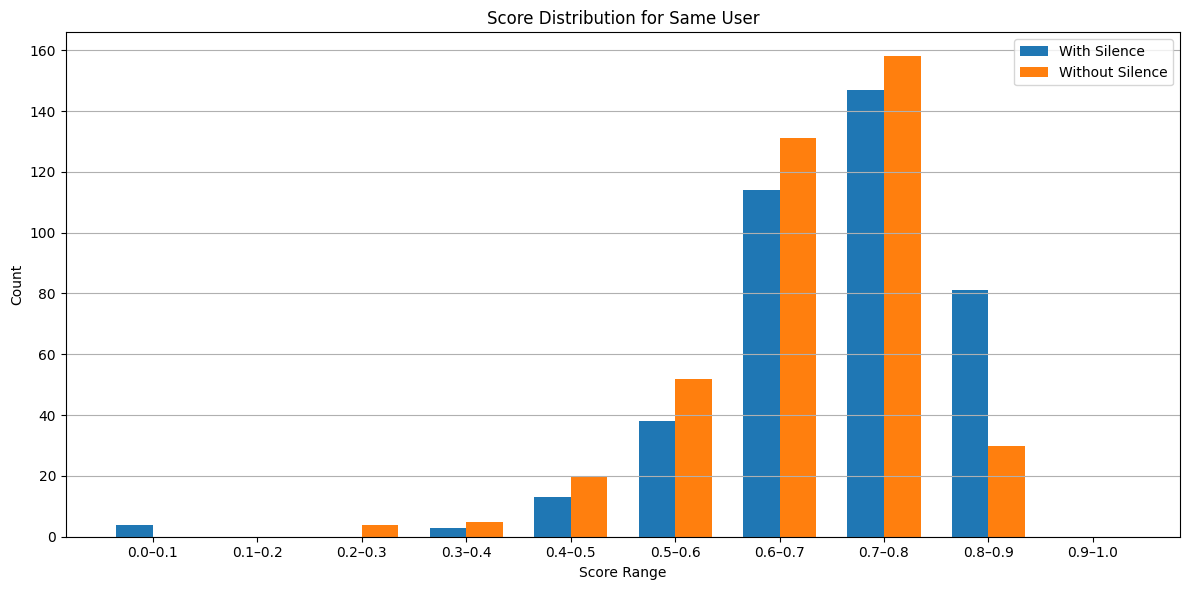

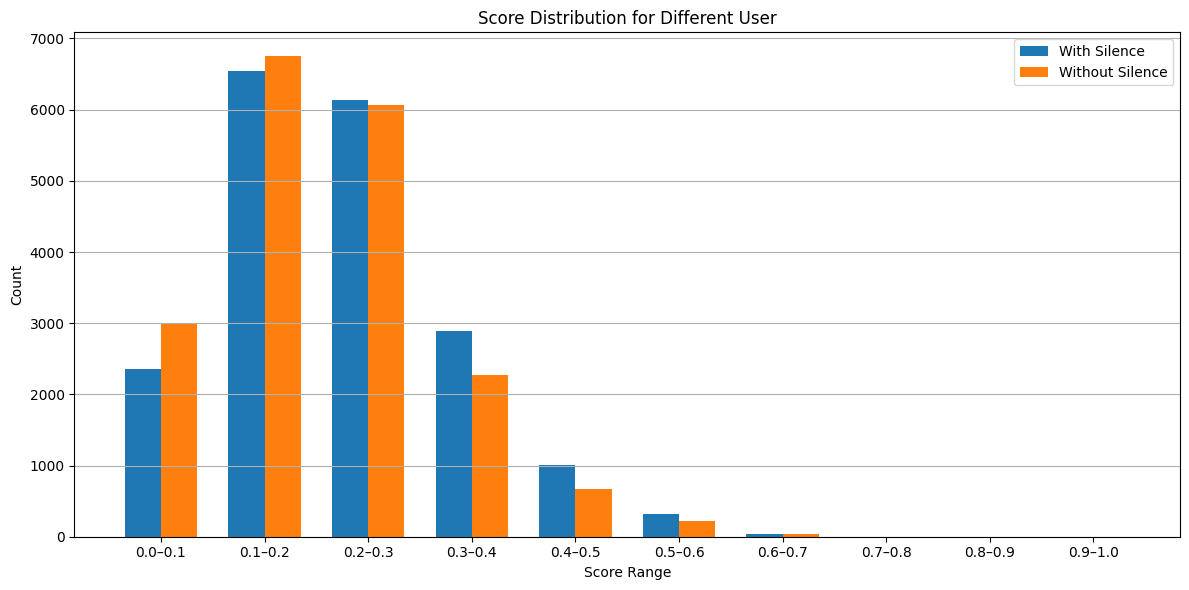

('./same_user_score_distribution.png',
 './different_user_score_distribution.png')

In [3]:
# Re-import necessary modules after state reset
import matplotlib.pyplot as plt
import numpy as np

# Data from the summary table
ranges = [
    "0.0–0.1", "0.1–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5",
    "0.5–0.6", "0.6–0.7", "0.7–0.8", "0.8–0.9", "0.9–1.0"
]
same_score = [4, 0, 0, 3, 13, 38, 114, 147, 81, 0]
same_nonoise = [0, 0, 4, 5, 20, 52, 131, 158, 30, 0]
diff_score = [2353, 6544, 6131, 2889, 1003, 314, 44, 0, 0, 0]
diff_nonoise = [2992, 6749, 6059, 2276, 677, 215, 44, 1, 0, 0]

x = np.arange(len(ranges))
width = 0.35  # width of the bars

# Plot for Same User
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, same_score, width, label='With Silence')
ax.bar(x + width/2, same_nonoise, width, label='Without Silence')
ax.set_title('Score Distribution for Same User')
ax.set_xlabel('Score Range')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(ranges)
ax.legend()
plt.tight_layout()
plt.grid(True, axis='y')

# Save same user plot

same_user_plot_path = './same_user_score_distribution.png'
plt.savefig(same_user_plot_path)
plt.show()

# Plot for Different User
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, diff_score, width, label='With Silence')
ax.bar(x + width/2, diff_nonoise, width, label='Without Silence')
ax.set_title('Score Distribution for Different User')
ax.set_xlabel('Score Range')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(ranges)
ax.legend()
plt.tight_layout()
plt.grid(True, axis='y')

# Save different user plot
diff_user_plot_path = './different_user_score_distribution.png'
plt.savefig(diff_user_plot_path)
plt.show()

same_user_plot_path, diff_user_plot_path
